In [14]:
# ===============================
# Comprehensive Pipeline for Sentiment Analysis with Enhanced Preprocessing,
# Clustering Visualizations, and Supervised Learning Improvements
# ===============================

# Importing required libraries
import pandas as pd
import numpy as np
import re, string, emoji
import matplotlib.pyplot as plt
import seaborn as sns

from bs4 import BeautifulSoup

# NLTK and Text Processing
import nltk
# nltk.download('punkt')
# nltk.download('stopwords')
# nltk.download('wordnet')
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer, PorterStemmer

# WordCloud visualization
from wordcloud import WordCloud

# Sentiment Analysis Libraries
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from textblob import TextBlob
import flair
from transformers import pipeline

# Machine Learning & Evaluation
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, silhouette_score

# Additional dimensionality reduction for visualization
from sklearn.manifold import TSNE

# Oversampling to address imbalance
from imblearn.over_sampling import SMOTE

# Classifiers
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier

import warnings
warnings.filterwarnings('ignore')

In [5]:
# ===============================
# 1. Data Loading & Preprocessing Functions
# ===============================

# Define preprocessing functions
def to_lowercase(text):
    return text.lower()

def remove_html_tags(text):
    if "<" in text and ">" in text:  
        return BeautifulSoup(text, "html.parser").get_text()
    return text  

def remove_urls(text):
    return re.sub(r'http\S+|www\S+', '', text)

def remove_punctuation(text):
    return text.translate(str.maketrans('', '', string.punctuation))

def remove_special_chars(text):
    return re.sub(r'[^a-zA-Z0-9\s]', '', text)

def tokenize(text):
    return word_tokenize(text)

def remove_stopwords(tokens):
    stop_words = set(stopwords.words('english'))
    return [word for word in tokens if word not in stop_words]

def convert_emojis(text):
    return emoji.demojize(text, delimiters=(" ", " "))

def lemmatize(tokens):
    lemmatizer = WordNetLemmatizer()
    return [lemmatizer.lemmatize(word) for word in tokens]

def preprocess_text(text):
    if not isinstance(text, str):
        return ""
    text = to_lowercase(text)
    text = remove_html_tags(text)
    text = remove_urls(text)
    text = convert_emojis(text)
    text = remove_punctuation(text)
    text = remove_special_chars(text)
    tokens = tokenize(text)
    tokens = remove_stopwords(tokens)
    tokens = lemmatize(tokens)
    return " ".join(tokens)



In [6]:
# ===============================
# 2. Read Data and Preprocess Text
# ===============================

# File path (update as needed)
file_path = "../Data/processed/Final_Noon_Datasets.csv"
df = pd.read_csv(file_path)

# Assuming the original text column is named 'comment_text'
df['processed_comment'] = df['comment_text'].apply(preprocess_text)


print("Sample of preprocessed data:")
print(df[['comment_text', 'processed_comment']].head())

Sample of preprocessed data:
                                        comment_text  \
0                          will reach border by noon   
1  Be careful of blowing dust during late morning...   
2  Apart from boring things, you can managed. How...   
3  You are looking at a tag in noon app saying 1 ...   
4  Are you sure? There's nothing indicating that ...   

                                   processed_comment  
0                                  reach border noon  
1  careful blowing dust late morning noon sand he...  
2  apart boring thing managed however light pole ...  
3  looking tag noon app saying 1 year warranty sa...  
4  sure there nothing indicating reading noon war...  


In [7]:
# ===============================
# 3. Sentiment Analysis & Target Value Generation
# ===============================

# Initialize sentiment analyzers
vader_analyzer = SentimentIntensityAnalyzer()
# Load Flair sentiment classifier (this might take time on first run)
flair_analyzer = flair.models.TextClassifier.load('en-sentiment')
# Hugging Face pipelines for RoBERTa and Longformer sentiment classification
roberta_classifier = pipeline("sentiment-analysis", model="cardiffnlp/twitter-roberta-base-sentiment")
longformer_classifier = pipeline("sentiment-analysis", model="allenai/longformer-base-4096")

# Customize VADER's lexicon with domain-specific words
new_words = {
    "falsely advertised": -3.0,
    "overheating": -3.0,
    "returned": -2.0,
    "refunds": -1.5,
    "fortunate": 0.5
}
vader_analyzer.lexicon.update(new_words)

# Define sentiment functions
def get_vader_sentiment(text):
    if not isinstance(text, str):
        return "Neutral"
    score = vader_analyzer.polarity_scores(text)['compound']
    return "Negative" if score <= -0.05 else "Positive" if score >= 0.05 else "Neutral"

def get_textblob_sentiment(text):
    if not isinstance(text, str):
        return "Neutral"
    score = TextBlob(text).sentiment.polarity
    return "Positive" if score > 0 else "Negative" if score < 0 else "Neutral"

def get_flair_sentiment(text):
    if not isinstance(text, str) or text.strip() == "":
        return "Neutral"
    sentence = flair.data.Sentence(text)
    flair_analyzer.predict(sentence)
    if not sentence.labels:
        return "Neutral"
    sentiment = sentence.labels[0].value
    return "Positive" if sentiment == 'POSITIVE' else "Negative" if sentiment == 'NEGATIVE' else "Neutral"

def get_roberta_sentiment(text, max_length=512, overlap=128):
    if not isinstance(text, str):
        return "Neutral"
    chunks = []
    i = 0
    while i < len(text):
        chunks.append(text[i:i + max_length])
        i += max_length - overlap
    sentiment_scores = {"Positive": 0, "Negative": 0, "Neutral": 0}
    for chunk in chunks:
        result = roberta_classifier(chunk)[0]
        # Mapping model-specific labels
        if result['label'] == 'LABEL_2':  # Positive
            sentiment_scores["Positive"] += 1
        elif result['label'] == 'LABEL_0':  # Negative
            sentiment_scores["Negative"] += 1
        else:
            sentiment_scores["Neutral"] += 1
    return max(sentiment_scores, key=sentiment_scores.get)

def get_longformer_sentiment(text, max_length=4096, overlap=512):
    if not isinstance(text, str):
        return "Neutral"
    chunks = []
    i = 0
    while i < len(text):
        chunks.append(text[i:i + max_length])
        i += max_length - overlap
    sentiment_scores = {"Positive": 0, "Negative": 0, "Neutral": 0}
    for chunk in chunks:
        result = longformer_classifier(chunk)[0]
        label = result['label']
        if "pos" in label.lower():
            sentiment_scores["Positive"] += 1
        elif "neg" in label.lower():
            sentiment_scores["Negative"] += 1
        else:
            sentiment_scores["Neutral"] += 1
    return max(sentiment_scores, key=sentiment_scores.get)

def get_adjusted_sentiment(text):
    negative_keywords = ["falsely advertised", "overheating", "returned", "refund", "issue"]
    positive_keywords = ["fortunately", "buy a new one"]
    neg_count = sum(1 for word in negative_keywords if word in text.lower())
    pos_count = sum(1 for word in positive_keywords if word in text.lower())
    if neg_count > pos_count:
        return "Negative"
    elif pos_count > neg_count:
        return "Positive"
    else:
        return "Neutral"

# Apply sentiment functions to the processed comments
print("\nStarted the sentiment analysis\n")
df['Sentiment_VADER'] = df['processed_comment'].apply(get_vader_sentiment)
df['Sentiment_TextBlob'] = df['processed_comment'].apply(get_textblob_sentiment)
df['Sentiment_Flair'] = df['processed_comment'].apply(get_flair_sentiment)
df['Sentiment_RoBERTa'] = df['processed_comment'].apply(get_roberta_sentiment)
df['Sentiment_Longformer'] = df['processed_comment'].apply(get_longformer_sentiment)
df['Sentiment_Adjusted'] = df['processed_comment'].apply(get_adjusted_sentiment)

# Calculate the final 5-point rating using a rule-based approach
def calculate_rating(row):
    sentiments = [
        row['Sentiment_VADER'],
        row['Sentiment_TextBlob'],
        row['Sentiment_Flair'],
        row['Sentiment_RoBERTa'],
        row['Sentiment_Longformer'],
        row['Sentiment_Adjusted']
    ]
    positive_count = sentiments.count("Positive")
    negative_count = sentiments.count("Negative")
    if positive_count >= 4:
        return 5
    elif positive_count == 3:
        return 4
    elif negative_count == 3:
        return 2
    elif negative_count >= 4:
        return 1
    else:
        return 3

df['Sentiment_Rating'] = df.apply(calculate_rating, axis=1)
print("Sentiment analysis complete. Sample:")
print(df.head())




Started the sentiment analysis

Sentiment analysis complete. Sample:
   post_id                                     post_title comment_id  \
0  1ibzgq5  Dubai to Riyadh - Which Road to Take? 1 or 2?    m9mjkdv   
1  1ibzgq5  Dubai to Riyadh - Which Road to Take? 1 or 2?    m9mgv03   
2  1ibzgq5  Dubai to Riyadh - Which Road to Take? 1 or 2?    m9mfqls   
3  1i9vydl                   Warranty from Noon or Amazon    m9lj27y   
4  1i9vydl                   Warranty from Noon or Amazon    m9lhuq1   

             author                                       comment_text  score  \
0    99DragonMaster                          will reach border by noon      2   
1   AgileBadger5988  Be careful of blowing dust during late morning...      9   
2     jamesdongdong  Apart from boring things, you can managed. How...      1   
3  Agitated-Fox2818  You are looking at a tag in noon app saying 1 ...      2   
4             m2bop  Are you sure? There's nothing indicating that ...      1   

          

In [8]:
# Save the preprocessed data to excel to ensure above data isnt reused
output_path = "../Data/processed/Final_Noon_Datasets_Preprocessed_sentiment.xlsx"
df.to_excel(output_path, index=False)
print(f"Preprocessing complete. Results saved to {output_path}")


Preprocessing complete. Results saved to ../Data/processed/Final_Noon_Datasets_Preprocessed_sentiment.xlsx


In [17]:
# Excel extracted from File path provided 
file_path = "../Data/processed/Final_Noon_Datasets_Preprocessed_sentiment.xlsx"
df_procs_sentiment = pd.read_excel(file_path)

In [19]:

# ===============================
# 4. Remove Neutral Reviews and Train-Test Split
# ===============================
# Remove neutral comments (rating == 3)
df_filtered_non_neutral = df_procs_sentiment[df_procs_sentiment['Sentiment_Rating'] != 3].copy()
print(f"\nFiltered dataset (removing neutral comments): {df_filtered_non_neutral.shape[0]} samples remain.")

X = df_filtered_non_neutral['processed_comment']
y = df_filtered_non_neutral['Sentiment_Rating']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)
print(f"\nTrain-test split completed: {X_train.shape[0]} training samples and {X_test.shape[0]} testing samples.")



Filtered dataset (removing neutral comments): 1687 samples remain.

Train-test split completed: 1349 training samples and 338 testing samples.


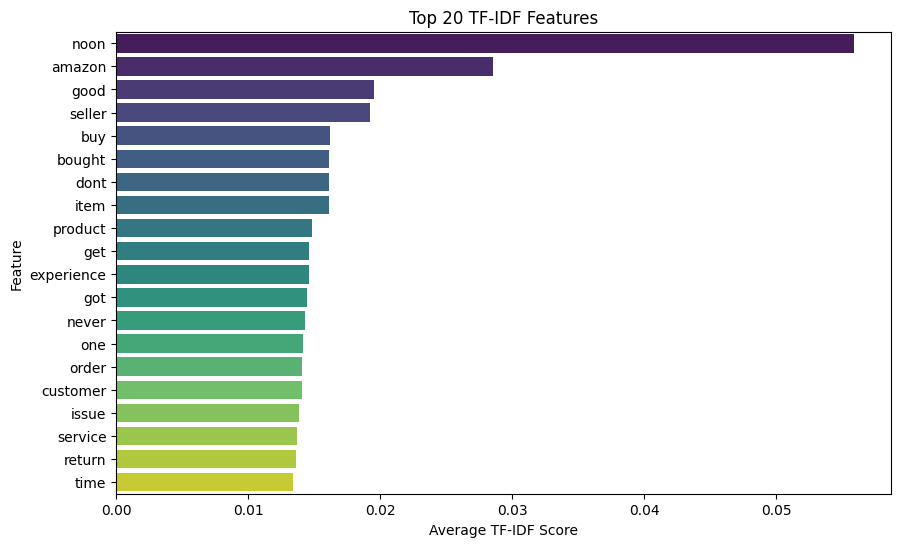

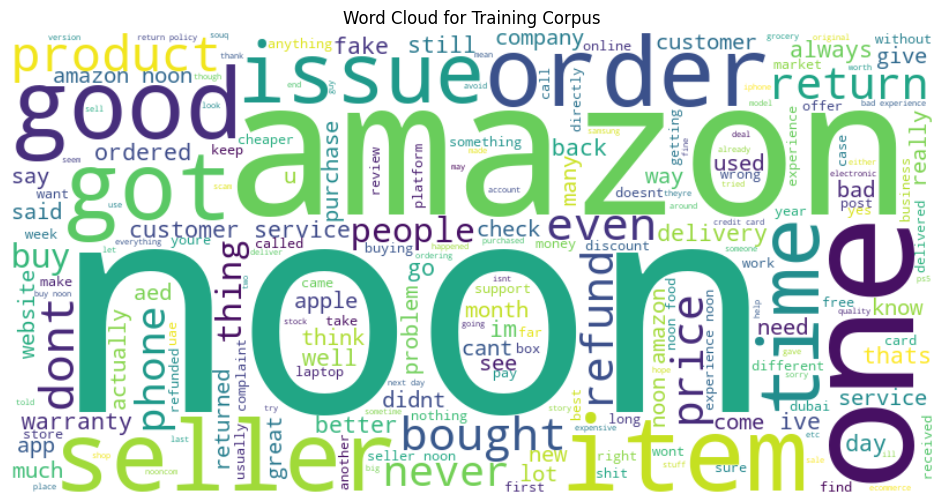

In [20]:
# ===============================
# 5. Vectorization and Extended Visualizations
# ===============================
# Use TF-IDF with unigrams and bigrams to enrich feature representation
tfidf_vectorizer = TfidfVectorizer(max_features=5000, ngram_range=(1,2))
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_test_tfidf = tfidf_vectorizer.transform(X_test)

# Visualize top 20 TF-IDF features (by average score)
feature_names = np.array(tfidf_vectorizer.get_feature_names_out())
tfidf_means = np.asarray(X_train_tfidf.mean(axis=0)).ravel()
top_n = 20
topn_idx = tfidf_means.argsort()[-top_n:][::-1]
top_features = feature_names[topn_idx]
top_scores = tfidf_means[topn_idx]

plt.figure(figsize=(10, 6))
sns.barplot(x=top_scores, y=top_features, palette="viridis")
plt.title("Top 20 TF-IDF Features")
plt.xlabel("Average TF-IDF Score")
plt.ylabel("Feature")
plt.show()

# Generate a word cloud of the corpus
all_text = " ".join(X_train)
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(all_text)
plt.figure(figsize=(12, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title("Word Cloud for Training Corpus")
plt.show()

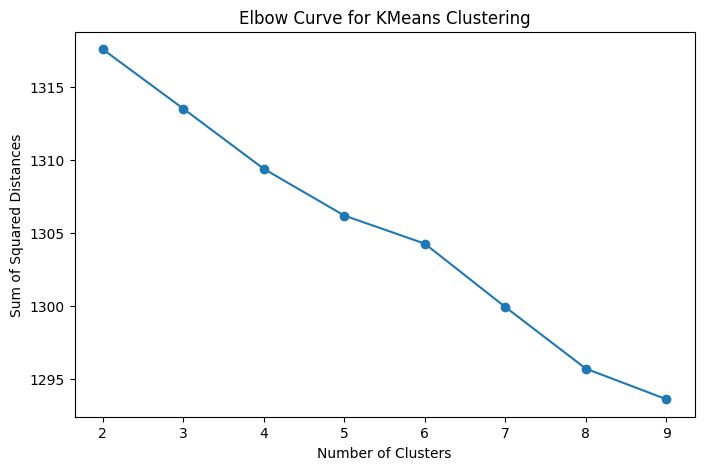

Silhouette Score for 3 clusters: 0.003


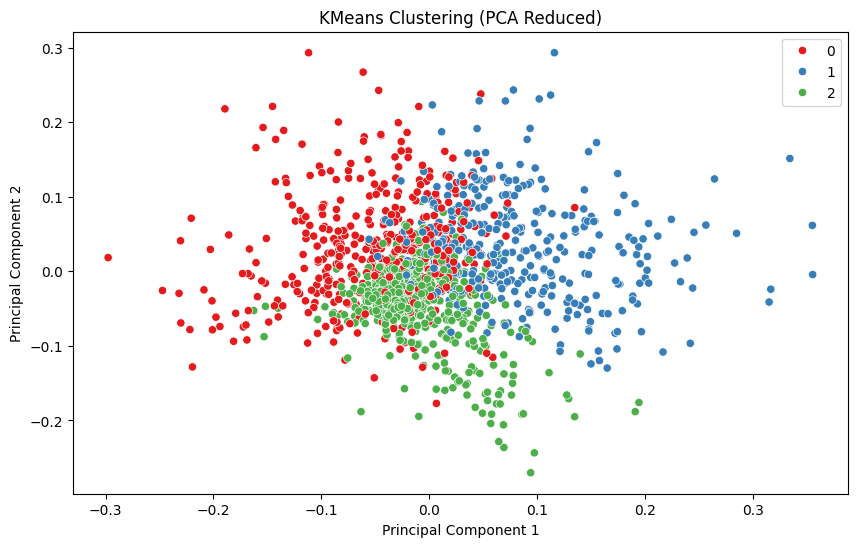

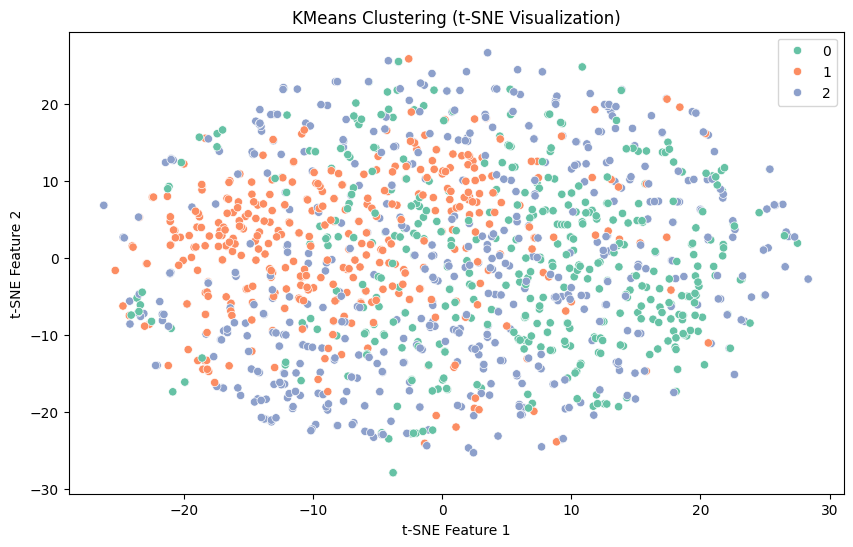

In [21]:
# ===============================
# 6. Clustering and Enhanced Visualizations
# ===============================
# Determine optimal number of clusters using the elbow method
sse = []
cluster_range = range(2, 10)
for k in cluster_range:
    km = KMeans(n_clusters=k, random_state=42)
    km.fit(X_train_tfidf)
    sse.append(km.inertia_)

plt.figure(figsize=(8, 5))
plt.plot(cluster_range, sse, marker='o')
plt.title("Elbow Curve for KMeans Clustering")
plt.xlabel("Number of Clusters")
plt.ylabel("Sum of Squared Distances")
plt.show()

# Choose number of clusters (for demonstration, using 3 clusters)
num_clusters = 3
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
cluster_labels = kmeans.fit_predict(X_train_tfidf)

# Calculate silhouette score
sil_score = silhouette_score(X_train_tfidf, cluster_labels)
print(f"Silhouette Score for {num_clusters} clusters: {sil_score:.3f}")

# PCA visualization
pca = PCA(n_components=2, random_state=42)
X_train_pca = pca.fit_transform(X_train_tfidf.toarray())
plt.figure(figsize=(10, 6))
sns.scatterplot(x=X_train_pca[:,0], y=X_train_pca[:,1], hue=cluster_labels, palette="Set1", legend='full')
plt.title("KMeans Clustering (PCA Reduced)")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.show()

# t-SNE visualization for enhanced cluster visualization
tsne = TSNE(n_components=2, random_state=42, perplexity=40, n_iter=300)
X_train_tsne = tsne.fit_transform(X_train_tfidf.toarray())
plt.figure(figsize=(10, 6))
sns.scatterplot(x=X_train_tsne[:,0], y=X_train_tsne[:,1], hue=cluster_labels, palette="Set2", legend='full')
plt.title("KMeans Clustering (t-SNE Visualization)")
plt.xlabel("t-SNE Feature 1")
plt.ylabel("t-SNE Feature 2")
plt.show()

In [22]:
# ===============================
# 7. Oversampling Minority Classes with SMOTE (to help boost accuracy)
# ===============================
smote = SMOTE(random_state=42)
X_train_tfidf_res, y_train_res = smote.fit_resample(X_train_tfidf, y_train)
print("After SMOTE, class distribution:", pd.Series(y_train_res).value_counts())


After SMOTE, class distribution: Sentiment_Rating
4    389
2    389
1    389
5    389
Name: count, dtype: int64



Training Naive Bayes ...
Naive Bayes Accuracy: 0.4822
Classification Report:
              precision    recall  f1-score   support

           1       0.57      0.59      0.58        94
           2       0.45      0.43      0.44        84
           4       0.46      0.42      0.44        99
           5       0.43      0.49      0.46        61

    accuracy                           0.48       338
   macro avg       0.48      0.48      0.48       338
weighted avg       0.48      0.48      0.48       338



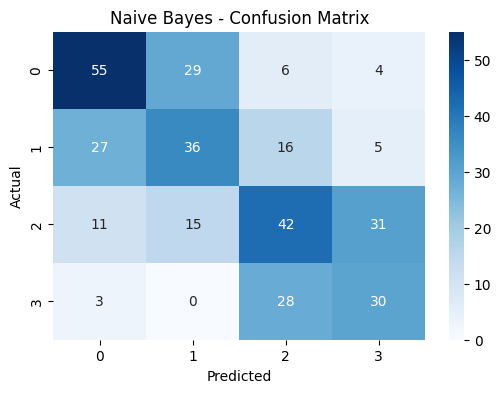


Training K-Nearest Neighbors ...
K-Nearest Neighbors Accuracy: 0.2219
Classification Report:
              precision    recall  f1-score   support

           1       0.55      0.06      0.11        94
           2       0.38      0.10      0.15        84
           4       0.39      0.07      0.12        99
           5       0.19      0.89      0.31        61

    accuracy                           0.22       338
   macro avg       0.38      0.28      0.17       338
weighted avg       0.39      0.22      0.16       338



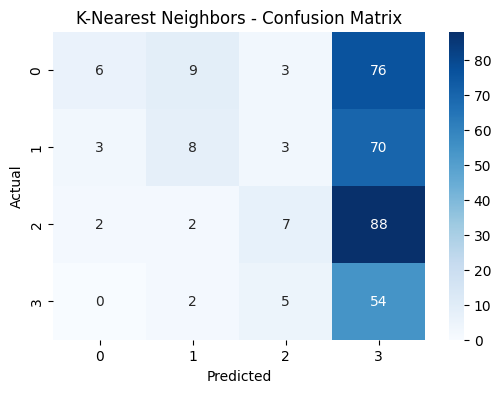


Training Support Vector Machine ...
Support Vector Machine Accuracy: 0.5148
Classification Report:
              precision    recall  f1-score   support

           1       0.64      0.59      0.61        94
           2       0.45      0.52      0.48        84
           4       0.49      0.51      0.50        99
           5       0.49      0.41      0.45        61

    accuracy                           0.51       338
   macro avg       0.52      0.51      0.51       338
weighted avg       0.52      0.51      0.52       338



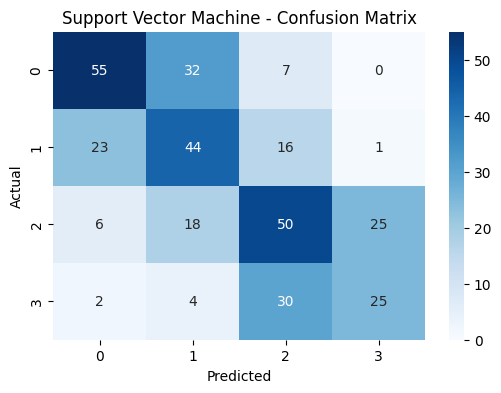


Training Logistic Regression ...
Logistic Regression Accuracy: 0.5207
Classification Report:
              precision    recall  f1-score   support

           1       0.60      0.60      0.60        94
           2       0.47      0.50      0.48        84
           4       0.50      0.48      0.49        99
           5       0.51      0.49      0.50        61

    accuracy                           0.52       338
   macro avg       0.52      0.52      0.52       338
weighted avg       0.52      0.52      0.52       338



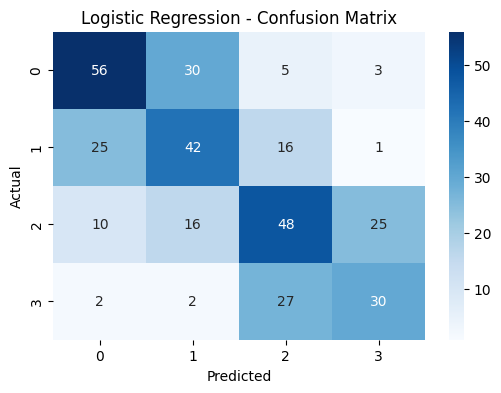


Training Neural Network ...
Neural Network Accuracy: 0.4941
Classification Report:
              precision    recall  f1-score   support

           1       0.59      0.56      0.58        94
           2       0.45      0.49      0.47        84
           4       0.47      0.45      0.46        99
           5       0.45      0.46      0.46        61

    accuracy                           0.49       338
   macro avg       0.49      0.49      0.49       338
weighted avg       0.50      0.49      0.49       338



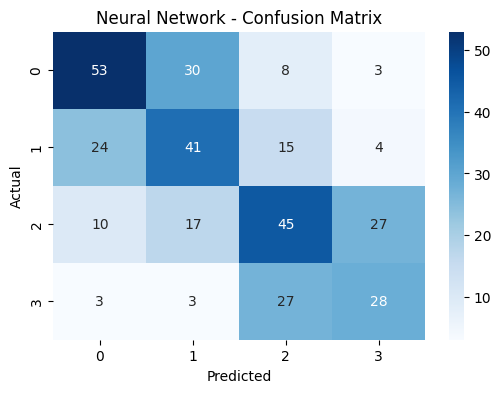

In [23]:
# ===============================
# 8. Supervised Learning: Model Training, Hyperparameter Tuning & Evaluation
# ===============================
# We incorporate GridSearchCV for SVM and Logistic Regression to improve performance.
models = {}

# Naive Bayes
models["Naive Bayes"] = MultinomialNB()

# K-Nearest Neighbors
models["K-Nearest Neighbors"] = KNeighborsClassifier()

# Support Vector Machine with GridSearch
svm_params = {
    'C': [0.1, 1, 10],
    'kernel': ['linear', 'rbf']
}
svm_grid = GridSearchCV(SVC(probability=True, random_state=42), svm_params, cv=3, n_jobs=-1)
models["Support Vector Machine"] = svm_grid

# Logistic Regression with GridSearch
lr_params = {
    'C': [0.1, 1, 10],
    'penalty': ['l2'],
    'max_iter': [1000]
}
lr_grid = GridSearchCV(LogisticRegression(random_state=42), lr_params, cv=3, n_jobs=-1)
models["Logistic Regression"] = lr_grid

# Neural Network
models["Neural Network"] = MLPClassifier(hidden_layer_sizes=(100,), max_iter=300, random_state=42)

results = {}

for name, model in models.items():
    print(f"\nTraining {name} ...")
    # Fit on the resampled training data (SMOTE applied)
    model.fit(X_train_tfidf_res, y_train_res)
    y_pred = model.predict(X_test_tfidf)
    
    acc = accuracy_score(y_test, y_pred)
    report = classification_report(y_test, y_pred, output_dict=True)
    cm = confusion_matrix(y_test, y_pred)
    
    results[name] = {"accuracy": acc, "report": report, "confusion_matrix": cm}
    
    print(f"{name} Accuracy: {acc:.4f}")
    print("Classification Report:")
    print(classification_report(y_test, y_pred))
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
    plt.title(f"{name} - Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()


In [ ]:
# ===============================
# 9. Model Selection and Measures to Improve Accuracy
# ===============================
# In our experiments, if accuracy is below 80%, consider:
#   • Tuning hyperparameters further with a wider grid.
#   • Using more advanced feature engineering (e.g., including trigrams, domain-specific embeddings).
#   • Employing ensemble methods (voting, stacking).
#   • Exploring deep learning models or fine-tuning transformer-based architectures.
#   • Collecting more training data or better cleaning the data.
#
# Here, we select the best model based on accuracy.
best_model_name = max(results, key=lambda x: results[x]["accuracy"])
print(f"\nBest performing model: {best_model_name} with Accuracy: {results[best_model_name]['accuracy']:.4f}")

# Optionally, save the best model for deployment.